## The PDE example

The PDE equation is:

$$\frac{\partial \phi}{\partial t}=-u\frac{\partial \phi}{\partial x}$$

With the initial value:
$$\phi_0 = \phi(x,0)$$

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

# tf.compat.v1.disable_eager_execution()

# 1. Build model

## Model
https://weikaiwei.com/tf/tensorflow-2-mnist-2/

In [5]:
class solve_PDE_Model():
    def __init__(self, loss_calculator):
        self.loss_calculator = loss_calculator
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
        self.metrics = tf.keras.metrics.Mean(0.001)

        inputs = tf.keras.Input(shape=(2,), name="inputs")
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer1')(inputs)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer2')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer3')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer4')(x)
        x = tf.keras.layers.Dense(units=20, activation=tf.nn.sigmoid, name='layer5')(x)
        outputs = tf.keras.layers.Dense(units=1, name='output')(x)
    
        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
            

    def predict(self, x_datax, t_data):
        print("Start prediction")
        return self.model(x_datax, t_data)

    def train(self, x_datax, t_data, epochs):
        print("Start training")
        self.metrics.reset_states()

        for epoch in range(epochs):
            self.train_epoch(x_datax, t_data)

            if(epoch%100 == 0):
                print("Epoch {0}, Loss {1}".format(epoch, self.metrics.result()))

    @tf.function
    def train_epoch(self, x_datax, t_data):
        with tf.GradientTape() as tape:
            input_data = tf.stack([tf.reshape(x_datax, [-1]), tf.reshape(dat_datata_t, [-1])], axis=1)
            # Run forward
            phi = self.model(input_data)
            # Compute the loss value
            loss = self.loss_calculator.loss(x_datax, t_data, phi)

        # Update metrics
        self.metrics.update_state(loss)

        # Compute gradients
        trainable_vars = self.model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        #Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))


## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [6]:
class PDE_Loss():
    def __init__(self, phi_init, u, regularization_factor=0.1):
        self.phi_init = phi_init
        self.u = u

    def loss(self, x_datax, t_data, phi):
        gradient = tf.gradients(phi, inputs)[0]
        
        phi_t, phi_x = tf.unstack(gradient,axis=1)
        
        phi_t = tf.reshape(phi_t, [phi_t.shape[0],1])
        phi_x = tf.reshape(phi_x, [phi_x.shape[0],1])
        
        governing_Eq = phi_t+self.u+phi_x
        
        init_size = self.phi_init.shape[0]

        number_of_time_step = governing_Eq.shape[0] / init_size
        
        loss = tf.reduce_mean(tf.square(phi[:init_size]-self.phi_init)) 

        for one_time_step in range(1, int(number_of_time_step)):
                    
            loss += tf.reduce_sum(tf.square(
                # governing_Eq in loss   
                governing_Eq[one_time_step*init_size+1:(one_time_step+1)*init_size-1]
            ))
    
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[one_time_step*init_size][0]-1.0) 
            ))
        
            loss += tf.reduce_mean(tf.square(
                 # bc in loss   
                (phi[(one_time_step+1)*init_size-1][0]-1.0)
            ))
                

        return loss
    


In [7]:

lx = 2
nx = 20
dx = lx / (nx-1)

lt = 0.05
nt = 3
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

# sine wave init
phi_init = np.ones(nx)

sineWave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sineWave)

phi_init = phi_init.reshape(phi_init.shape[0],-1)
phi_init = tf.constant(phi_init, dtype=tf.float32)

x_all = np.linspace(0, lx, nx)
x_all = tf.constant(x_all, dtype=tf.float32)

t_all = np.linspace(0, lt, nt)
t_all = tf.constant(t_all, dtype=tf.float32)

def combine(x, y):
  xx, yy = tf.meshgrid(x, y, indexing='ij')
  return tf.stack([tf.reshape(xx, [-1]), tf.reshape(yy, [-1])], axis=1)

inputs_all = combine(t_all,x_all)

print (inputs_all)
loss_calculator = PDE_Loss(phi_init,u)
myModel = solve_PDE_Model(loss_calculator)
myModel.train(inputs_all,50000)


7]
 [0.         0.94736844]
 [0.         1.0526316 ]
 [0.         1.1578947 ]
 [0.         1.2631578 ]
 [0.         1.3684211 ]
 [0.         1.4736842 ]
 [0.         1.5789474 ]
 [0.         1.6842105 ]
 [0.         1.7894737 ]
 [0.         1.8947369 ]
 [0.         2.        ]
 [0.025      0.        ]
 [0.025      0.10526316]
 [0.025      0.21052632]
 [0.025      0.31578946]
 [0.025      0.42105263]
 [0.025      0.5263158 ]
 [0.025      0.6315789 ]
 [0.025      0.7368421 ]
 [0.025      0.84210527]
 [0.025      0.94736844]
 [0.025      1.0526316 ]
 [0.025      1.1578947 ]
 [0.025      1.2631578 ]
 [0.025      1.3684211 ]
 [0.025      1.4736842 ]
 [0.025      1.5789474 ]
 [0.025      1.6842105 ]
 [0.025      1.7894737 ]
 [0.025      1.8947369 ]
 [0.025      2.        ]
 [0.05       0.        ]
 [0.05       0.10526316]
 [0.05       0.21052632]
 [0.05       0.31578946]
 [0.05       0.42105263]
 [0.05       0.5263158 ]
 [0.05       0.6315789 ]
 [0.05       0.7368421 ]
 [0.05       0.8421052

In [11]:
result = myModel.predict(inputs_all)

Start prediction


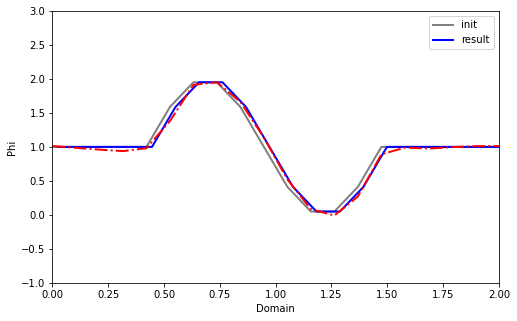

In [13]:
import matplotlib.pyplot as plt

%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(8,5))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
ax1.set_xlim((0, 2))            
ax1.set_ylim((-1, 3))
ax1.set_xlabel('Domain')
ax1.set_ylabel('Phi')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
n=1
txt_title = ax1.set_title('')
line1, = ax1.plot(x_all, phi_init, 'gray', lw=2)     # ax.plot returns a list of 2D line objects
line1, = ax1.plot(x_all+dt*n*u, phi_init, 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot(x_all, result[n*nx:(n+1)*nx], 'r-.', lw=2)     # ax.plot returns a list of 2D line objects
ax1.legend(['init','result'])

In [44]:
lx = 2
nx = 6
dx = lx / (nx-1)

lt = 0.05
nt = 3
dt = lt / (nt-1)

u = 1      #assume wavespeed of u = 1

x = tf.linspace(0.0, lx, nx, name="x")
t = tf.linspace(0.0, lt, nt, name="t")
x_init = tf.identity(x, name="x_init")
x, t = tf.meshgrid(x, t)


# sine wave init
np_phi_init = np.ones(nx)
sine_wave = np.linspace(0,2*np.pi, int(1.5 / dx + 1) - int(.5 / dx) )
np_phi_init[int(.5 / dx):int(1.5 / dx + 1)] += np.sin(sine_wave)
phi_init = tf.convert_to_tensor(np_phi_init, dtype=tf.float32, name="phi_init")

loss_calculator = PDE_Loss(phi_init,u)
myModel = solve_PDE_Model(loss_calculator)
myModel.train(x, t, 50000)


<tf.Tensor: shape=(18, 2), dtype=float32, numpy=
array([[0.   , 0.   ],
       [0.4  , 0.   ],
       [0.8  , 0.   ],
       [1.2  , 0.   ],
       [1.6  , 0.   ],
       [2.   , 0.   ],
       [0.   , 0.025],
       [0.4  , 0.025],
       [0.8  , 0.025],
       [1.2  , 0.025],
       [1.6  , 0.025],
       [2.   , 0.025],
       [0.   , 0.05 ],
       [0.4  , 0.05 ],
       [0.8  , 0.05 ],
       [1.2  , 0.05 ],
       [1.6  , 0.05 ],
       [2.   , 0.05 ]], dtype=float32)>